In [67]:
%%HTML
<link rel="stylesheet" type="text/css" href="custom.css">

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"));

#### What’s the uncertainty on your ML prediction?

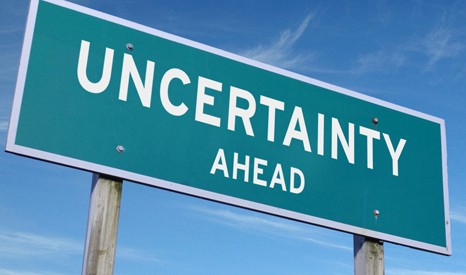

In [2]:
from IPython.display import Image
Image(filename='img/uncertainty.jpeg')

# Your presenters
- Eva van Weel
- Fabian Jansen

Data scientists @ ING  

We try not to be bankers

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../errortools/")
import errortools
import scipy.stats
import pandas as pd
import sklearn.preprocessing
import random

import matplotlib

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

matplotlib.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

matplotlib.rcParams['font.family'] = 'serif'

from IPython.display import Markdown, display
def Print(string):
    display(Markdown(string))
    
np.random.seed(42)
np.set_printoptions(precision=1)

/Users/faab/errortools/notebooks/pydata/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# You're throwing a dinner party

You expect 10 guests

Of course on the day it can be some more or some less

But how many more or less matters

**Uncertainty matters**

To our knowledge there is no package that calculates uncertainties  

So we're building our own

_Uncertainty/error_ = __how far__ we could be off in our prediction

Roughly two sources of uncertainty  

- Model, assumptions, features, processing, ...  

Sometimes called _systematic uncertainties_

This is not about those

- Limited training data  

Sometimes called _statistical uncertainties_

This is about those

# An illustrative example

We create a dataset according to a perfectly known sigmoid probability distribution  

In [4]:
n_traindata = 100
slope = 4 
bias  = 0

X = np.random.uniform(low=-1, high=1, size=n_traindata)
p = scipy.stats.logistic.cdf(X * slope + bias)
y = (p > np.random.uniform(size=n_traindata)).astype(int)

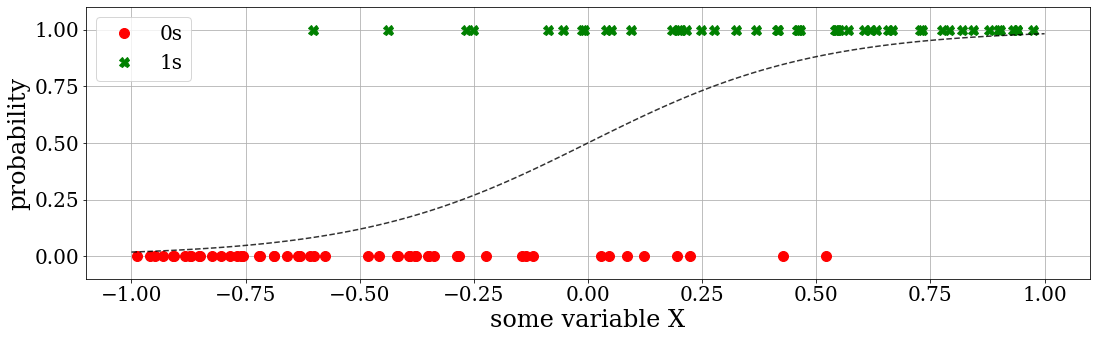

In [49]:
H, e = np.histogram(X, bins=10, range=(-1,1))
h, e = np.histogram(X[y==1], bins=10, range=(-1,1))
r = h/(H+1e-12)

fig, ax = plt.subplots(1, 1, figsize=(18, 5))
x = np.linspace(-1, 1, 101)
p = scipy.stats.logistic.cdf(slope * x + bias)
ax.plot(X[y==0], y[y==0], 'o', color='red', markersize=10, label="0s")
ax.plot(X[y==1], y[y==1], 'X', color='green', markersize=10, label="1s")
ax.plot(x, p, '--', color='black', alpha=0.8)
#ax.bar((e[:-1]+e[1:])/2., r, e[1]-e[0], color="orange", alpha=0.5, label="fraction of 1s")
ax.set_xlabel("some variable X")
ax.set_ylabel("probability")
ax.grid()
ax.legend()
ax.set_ylim((-0.1,1.1));

We fit a logistic regression to the dataset

In [6]:
model = errortools.LogisticRegression()
model.fit(X, y)
print(model.parameters)

[4.7 0.1]


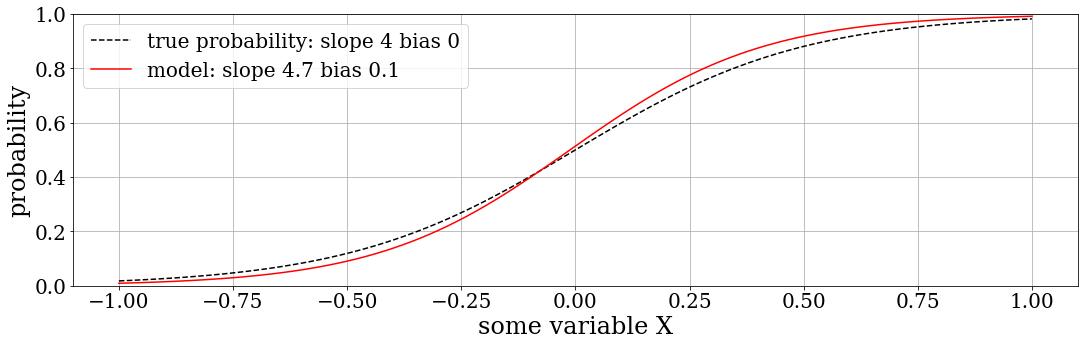

In [50]:
H, e = np.histogram(X, bins=10, range=(-1,1))
h, e = np.histogram(X[y==1], bins=10, range=(-1,1))
r = h/(H+1e-12)

fig, ax = plt.subplots(1, 1, figsize=(18, 5))
x = np.linspace(-1, 1, 101)
p = scipy.stats.logistic.cdf(slope * x + bias)
f = model.predict(x)
ax.plot(x, p, '--', color='black', alpha=1, label="true probability: slope {:.0f} bias {:.0f}".format(slope, bias))
#ax.bar((e[:-1]+e[1:])/2., r, e[1]-e[0], color="orange", alpha=0.1)
ax.plot(x, f, '-', color='red', alpha=1, label="model: slope {:.1f} bias {:.1f}".format(model.parameters[0], model.parameters[1]))
ax.set_xlabel("some variable X")
ax.set_ylabel("probability")
ax.grid()
ax.legend()
ax.set_ylim((0,1));

Our model does not get back the exact slope and bias that we put in  

The reason is the dataset  

If we had a different dataset, we would get different values

Let's illustrate this  
We repeat the example many times  

In [8]:
n_datasets = 1000
Xs = np.random.uniform(low=-1, high=1, size=(n_datasets, n_traindata))
ps = scipy.stats.logistic.cdf(Xs * slope + bias)
ys = (ps > np.random.uniform(size=Xs.shape)).astype(int)

In [9]:
models = []
for i in range(n_datasets):
    m = errortools.LogisticRegression()
    m.fit(Xs[i], ys[i])
    models.append(m)

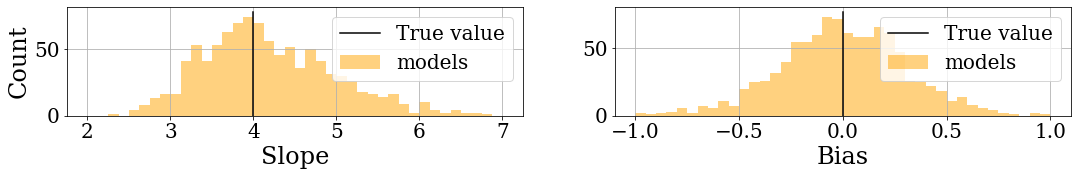

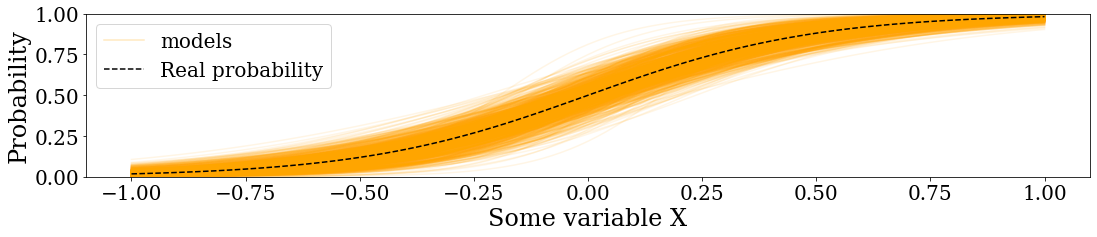

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(18,2))
ax[0].hist([m.parameters[0] for m in models], bins=40, range=(2,7), color='orange', alpha=0.5, label="models")
ax[0].plot((slope, slope), ax[0].get_ylim(), color='black', label="True value")
ax[0].grid()
ax[0].set_xlabel("Slope")
ax[0].set_ylabel("Count")
ax[0].legend()

ax[1].hist([m.parameters[1] for m in models], bins=40, range=(-1,1), color='orange', alpha=0.5, label="models")
ax[1].plot((bias, bias), ax[1].get_ylim(), color='black', label="True value")
ax[1].grid()
ax[1].set_xlabel("Bias")
ax[1].legend()

fig, ax = plt.subplots(1, 1, figsize=(18,3))
p = scipy.stats.logistic.cdf(slope * x + bias)
ax.plot(x, models[0].predict(x), '-', color='orange', alpha=0.25, label="models")
for m in models[1:]:
    ax.plot(x, m.predict(x), '-', color='orange', alpha=0.1)
ax.plot(x, p, '--', color='black', label="Real probability")
ax.set_ylim((0,1))
ax.set_xlabel("Some variable X")
ax.set_ylabel("Probability")
ax.legend();

### We see that

A model's parameters and prediction curves depend on the training data  

We thus have an uncertainty on our predictions  

# Estimating uncertainties

Two steps

1. Estimate uncertainties on model parameters

2. Propagate uncertainties to predictions

We'll show these steps with a real example

**Surviving the Titanic**

First we get the data that we need

In [11]:
df = pd.read_csv("http://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv")

In [12]:
df['sex'] = df.Sex.apply(lambda s: 1 if s=='female' else 0)

In [13]:
df.head(5)

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,sex
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500,0
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833,1
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250,1
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000,1
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500,0


Let's look at some data distributions

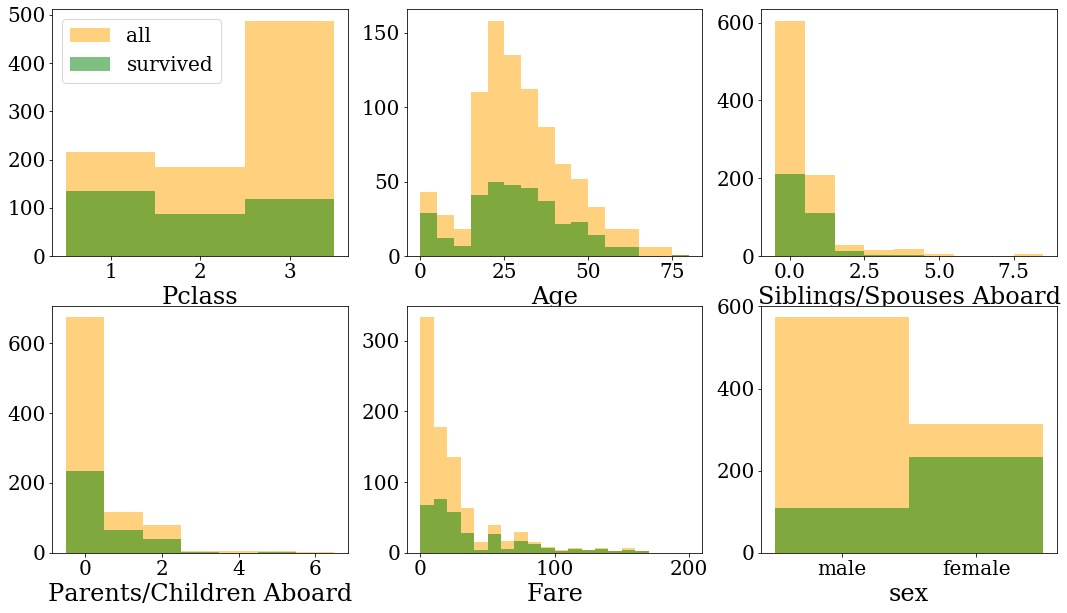

In [72]:
dfsurv = df[df.Survived==1]
dfdied = df[df.Survived==0]
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
ax[0,0].hist(df.Pclass, bins=3, range=(0.5,3.5), color='orange', alpha=0.5, label="all")
ax[0,0].hist(dfsurv.Pclass, bins=3, range=(0.5,3.5), color='green', alpha=0.5, label="survived")
ax[0,0].set_xlabel("Pclass")
ax[0,0].legend()

ax[0,1].hist(df.Age, bins=16, range=(0,80), color='orange', alpha=0.5, label="all")
ax[0,1].hist(dfsurv.Age, bins=16, range=(0,80), color='green', alpha=0.5, label="survived")
ax[0,1].set_xlabel("Age")

ax[0,2].hist(df['Siblings/Spouses Aboard'], bins=9, range=(-0.5,8.5), color='orange', alpha=0.5, label="all")
ax[0,2].hist(dfsurv['Siblings/Spouses Aboard'], bins=9, range=(-0.5,8.5), color='green', alpha=0.5, label="survived")
ax[0,2].set_xlabel("Siblings/Spouses Aboard")

ax[1,0].hist(df['Parents/Children Aboard'], bins=7, range=(-0.5,6.5), color='orange', alpha=0.5, label="all")
ax[1,0].hist(dfsurv['Parents/Children Aboard'], bins=7, range=(-0.5,6.5), color='green', alpha=0.5, label="survived")
ax[1,0].set_xlabel("Parents/Children Aboard")

ax[1,1].hist(df['Fare'], bins=20, range=(0,200), color='orange', alpha=0.5, label="all")
ax[1,1].hist(dfsurv['Fare'], bins=20, range=(0,200), color='green', alpha=0.5, label="survived")
ax[1,1].set_xlabel("Fare")

ax[1,2].hist(df['sex'], bins=2, range=(-0.5,1.5), color='orange', alpha=0.5, label="all")
ax[1,2].hist(dfsurv['sex'], bins=2, range=(-0.5,1.5), color='green', alpha=0.5, label="survived")
ax[1,2].set_xlabel("sex")
ax[1,2].get_xaxis().set_ticks([0,1])
ax[1,2].get_xaxis().set_ticklabels(['male', 'female']);

## Now let's train a model!

We define our features and target

In [15]:
features = ['Pclass', 'Age', 'Fare', 'Siblings/Spouses Aboard', 
            'Parents/Children Aboard', 'sex']
target = 'Survived'

Make a train-test split

In [16]:
df_train = df.sample(frac=0.5, replace=False, random_state=42)
df_test  = df.loc[df.index.difference(df_train.index)]

In [17]:
X_train = df_train[features].values
y_train = df_train[target].values

In [18]:
X_test = df_test[features].values
y_test = df_test[target].values

We scale our inputs, so we can compare fit parameters

In [19]:
scaler = sklearn.preprocessing.MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

We use our `LogisticRegression` class

In [20]:
titanic_model = errortools.LogisticRegression()
titanic_model.fit(X_train_scaled, y_train)
titanic_model.parameters

array([-1.9, -3.2,  5.6, -2.5, -0.6,  2.5,  1.1])

## 1. Estimate uncertainties on model parameters

When we fit, we minimize a loss function $L_{oss}(p; X, y)$  

__And implicitly maximise a likelihood__ $L(p|X,y)\sim e^{-L_{oss}(p; X, y)}$

The optimal model parameters
* minimize the loss function
* are the most likely parameters for the given dataset 

But surrounding parameter values are still likely  

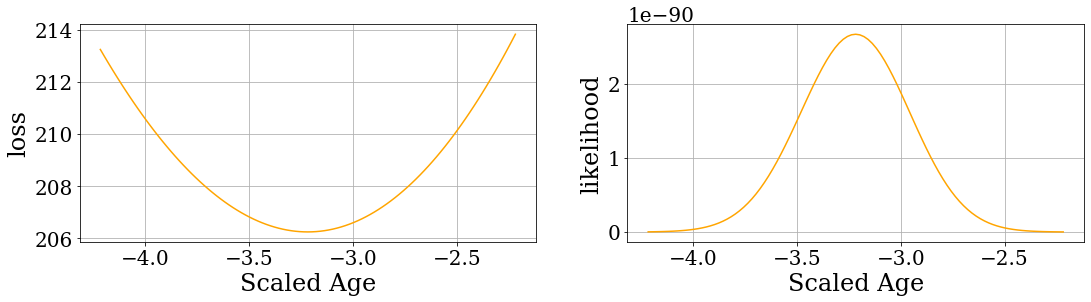

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
U = np.tile(titanic_model.parameters, (101,1))
U[:,1] += np.linspace(-1, 1, 101)
v = np.array([titanic_model.loss(u, X_train_scaled, y_train) for u in U])
ax[0].plot(U[:,1], v, '-', color='orange', label="loss")
ax[1].plot(U[:,1], np.exp(-v), '-', color='orange', label="likelihood")
ax[0].grid(); ax[1].grid(); ax[0].set_xlabel("Scaled Age"); ax[1].set_xlabel("Scaled Age");
ax[0].set_ylabel("loss"); ax[1].set_ylabel("likelihood");

To calculate which parameters are still likely  
* We make a parabolic approximation of the loss function [<sup>1</sup>](#fn1)  
* This turns the likelihood into a multivariate Gaussian distribution[<sup>2</sup>](#fn2)  

<span style="font-size:20px"> 1. $L_{oss}(p; X, y)\approx L_{oss}(p_0) + \frac{1}{2}(p-p_0)\cdot\frac{\partial^2 L_{oss}}{\partial p^2}\cdot(p-p_0)$<br></span>
<span style="font-size:20px"> 2. $L(p|X,y)\approx e^{-\frac{1}{2}(p-p_0)\cdot\frac{\partial^2 L_{oss}}{\partial p^2}\cdot(p-p_0)}$</span>


How good the approximation is,  
determines how good the error estimates are  

We created a reporting function to visualise this

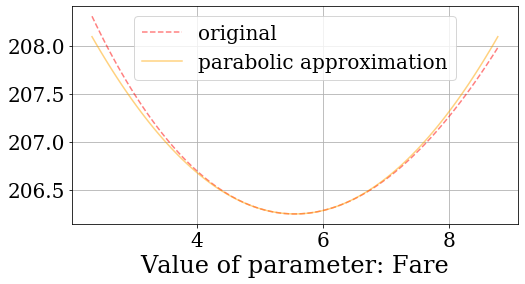

In [22]:
pdf, fig = errortools.report_loss_versus_approximation(titanic_model,
                                    features + ['bias']); pdf.close()
fig[2]

The parabolic approximation is pretty good

**The approximation automatically gives us the parameter errors.**  
They are given by the covariance matrix [<sup>1</sup>](#fn1)

* Diagonal elements give the parameter errors
* Off-diagonal elements give the parameter correlations

<span style="font-size:20px"> 1. $\hat{\Sigma}_{p} = \left[\frac{\partial^2 L_{oss}}{\partial p^2}\right]^{-1}$ </span>


In [31]:
titanic_model.errors

array([0.4, 0.8, 3.2, 1.2, 1. , 0.3, 0.6])

We have a reporting function to visualise the parameter errors

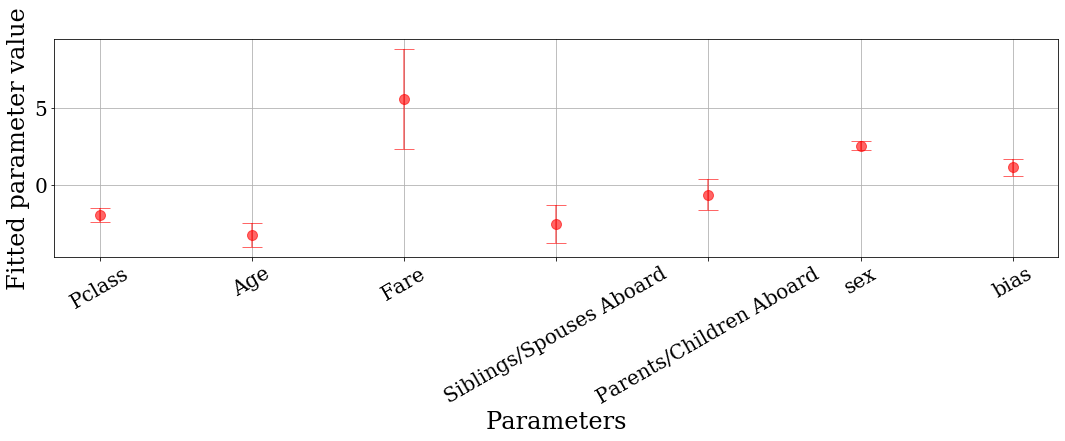

In [53]:
errortools.report_parameter_error(titanic_model, 
                                  features + ['bias'], 
                                  figsize=(18, 4), 
                                  rotation_x_labels=30).close();

## 2. Propagate uncertainties to predictions

A prediction is a function of input features $X$ and model parameters $p$  

* The most likely model parameters $p_0$ determine the prediction  

* **And the uncertainties in the parameters propagate to uncertainties in the prediction**

Sevaral ways to propagate errors, with benefits and drawbacks  

A common, fast way is "linear error propagation"

**Linear error propagation**  
   * We make a linear approximation of the prediction function [<sup>1</sup>](#fn1)
   * This makes the prediction error a simple equation[<sup>2</sup>](#fn2)
       
Fast calculation, but may be inexact    

<span style="font-size:20px"> 1. $f(X|p)\approx f(X|p_0)+\frac{\partial f}{\partial p}(X|p_0)\cdot(p-p_0)$ </span>  
<span style="font-size:20px"> 2. $\Delta f \approx  \sqrt{\frac{\partial f}{\partial p}(X|p_0) \cdot \hat{\Sigma}_p \cdot \frac{\partial f}{\partial p}(X|p_0)}$ </span>

# Let's apply this on our test set  

We make predictions

In [24]:
predictions = titanic_model.predict(X_test_scaled)

And we estimate errors on our predictions

In [25]:
prediction_errors, _ = titanic_model.prediction_errors(X_test_scaled, 
                                method='linear_error_propagation')

We have a reporting function that visualises predictions and errors

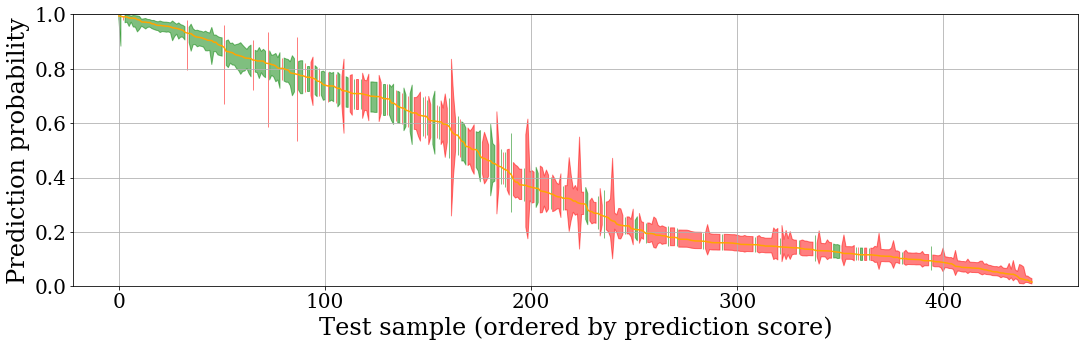

In [54]:
errortools.report_error_test_samples(titanic_model, 
                                     X_test_scaled,
                                     y_test,
                                     figsize=(18, 5)).close();

Except for predictions on test samples, we can make prediction curves

Let's take a person
* 42 year old 
* male 
* in third class 
* no family  

Let's visualise his survival probability as a function of Fare

In [57]:
person = [3.0, 42.0, 0., 0., 0., 0.]
scaled_person = scaler.transform([person])[0]

In [59]:
U = np.tile(scaled_person, (101,1))
U[:,2] += np.linspace(0, 1, 101)
v = titanic_model.predict(U)

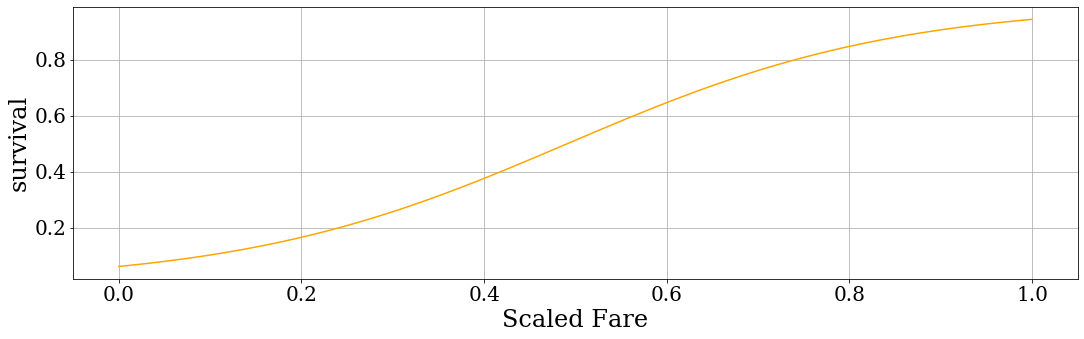

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
ax.plot(U[:,2], v, '-', color='orange')
ax.grid(); ax.set_xlabel("Scaled Fare"); ax.set_ylabel("survival");

It looks like if he payed enough he'll be saved  

But can he be so sure about that?

Let's look at the uncertainty

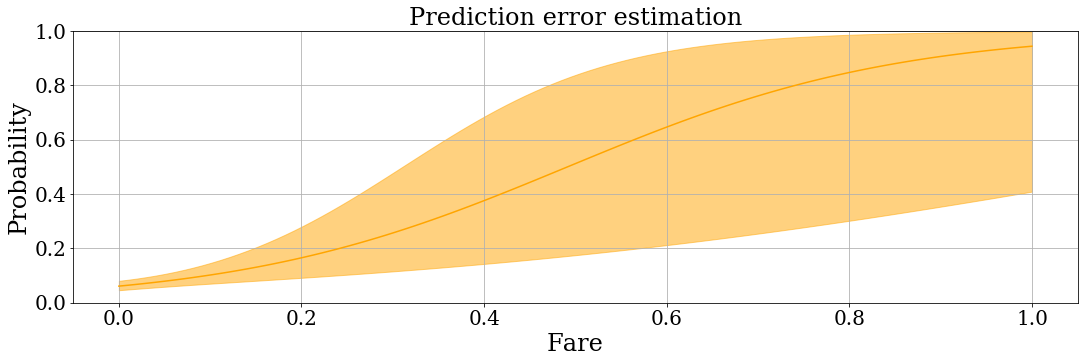

In [61]:
errortools.report_error_indivial_pred(titanic_model, 
                                      scaled_person, 
                                      'Fare', features, 0, 1, 100,
                                      figsize=(18,5))

**Not so certain of his survival now!**

# To recap

* We're creating a tool set that not only allows you to train models and make predictions  
* But also estimate uncertainties on those predictions
* And reporting functionalities to visualise the models

## What's next?

**We are far from done** (just starting in fact)   
https://github.com/faab5/errortools  
- Refactor code (so please be patient if you want to use)
- Available on Pypy
- Error estimation on metrics, like the confusion matrix
- Integrate models trained with sklearn
- Error estimation for regressors like $\chi^2$ fitter
- Error estimation for neural networks (a start has been made with Pytorch)
- ...

# Thank you

# Backup slides

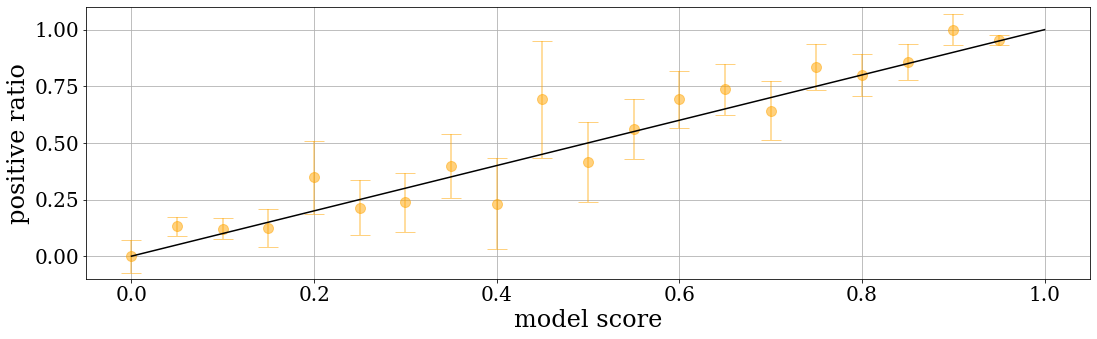

In [71]:
errortools.report_model_positive_ratio(titanic_model, 100, 20, pdf=None, pdf_name='report.pdf', figsize=(18,5)).close()